In [1]:
import numpy as np
import xarray as xr




In [2]:
def pole_correct_UV(dax, day, x="longitude", y="latitude"):
    """
    Correct U and V data so that it will plot nicely at the pole

    Parameters
    ----------
    dax, day : xarray.DataArray
        DataArrays for the x and y component of the vector arrow
    x : str, default 'longitude'
        Longitude coordinate name
    y : str, default 'latitude'
        Latitude coordinate name

    Returns
    -------
    bu,bv : corrected U and V components
    """

    lats, lons = dax[y].values, dax[x].values
    lon2d, lat2d = np.meshgrid(lons, lats)

    X, Y = dax.values, day.values

    X_src_crs = X / np.cos(lat2d / 180 * np.pi)
    Y_src_crs = Y
    magnitude = np.sqrt(X**2 + Y**2)
    magn_src_crs = np.sqrt(X_src_crs**2 + Y_src_crs**2)

    bu = X_src_crs * magnitude / magn_src_crs
    bv = Y_src_crs * magnitude / magn_src_crs

    return bu,bv,lon2d,lat2d

In [3]:

def add_streamline_plot_to_ax(dax, day, axs, x="longitude", y="latitude", **figkwargs):
    """
    Add a streamlines plot to a pre-existing set of axes

    Parameters
    ----------
    dax, day : xarray.DataArray
        DataArrays for the x and y component of the vector arrow
    axs : matplotlib.axes.Axes
    x : str, default 'longitude'
        Longitude coordinate name
    y : str, default 'latitude'
        Latitude coordinate name
    **figkwargs : optional
        An assortment of figkwargs. See the matplotlib.pyplot.streamplot documentation for details

    Returns
    -------
    p : matplotlib.pyplot.streamplot
    """



    lats, lons = dax[y].values, dax[x].values
    lon2d, lat2d = np.meshgrid(lons, lats)

    X, Y = dax.values, day.values

    X_src_crs = X / np.cos(lat2d / 180 * np.pi)
    Y_src_crs = Y
    magnitude = np.sqrt(X**2 + Y**2)
    magn_src_crs = np.sqrt(X_src_crs**2 + Y_src_crs**2)

    bu = X_src_crs * magnitude / magn_src_crs
    bv = Y_src_crs * magnitude / magn_src_crs

    lw = 25 * np.sqrt(bu**2 + bv**2)# / np.sqrt(bu**2 + bv**2).max()
    lw = np.nan_to_num(lw, nan=0.0)

    figkwargs = {
        "density": 4,
        "linewidth": lw,
        "arrowsize": 1,
        "color": magnitude,
        "cmap":'viridis',
        **figkwargs,
    }

    p = axs.streamplot(lon2d, lat2d, bu, bv, transform=ccrs.PlateCarree(), **figkwargs)

    cbar = plt.colorbar(p.lines, ax=ax, pad=0.05)
    cbar.set_label("Speed (m/s)")

    plt.title(f"Velocity Streamlines for year {year}")

    return p

In [4]:
ds = xr.open_dataset("/work/scratch-pw5/thopri/cmems_mod_arc_phy_my_topaz4_P1M_vyo-vxo_180.00W-179.88E_50.00N-90.00N_0.00-4000.00m_1991-01-01-2025-08-01.nc")

year = "1994"

u = ds["vxo"].sel(time=year).isel(depth=0).mean("time").compute()  # zonal (east-west)
v = ds["vyo"].sel(time=year).isel(depth=0).mean("time").compute()

u,v,X,Y = pole_correct_UV(u,v)
x = X[0,:]
y = Y[:,0]

dx = x[1] - x[0]
dy = y[1] - y[0]

ux = np.gradient(u, dx, axis=1)
uy = np.gradient(u, dy, axis=0)
vx = np.gradient(v, dx, axis=1)
vy = np.gradient(v, dy, axis=0)

In [5]:
speed = np.sqrt(u**2 + v**2)

# threshold relative to flow strength
thr = 0.05 * np.nanpercentile(speed, 90)
candidates = speed < thr
print(f"{sum(sum(candidates))} candidates found")

7321 candidates found


In [6]:
from scipy.ndimage import label, center_of_mass

labels, nlab = label(candidates)
centers = center_of_mass(candidates, labels, range(1, nlab+1))
print(f"{centers.__len__()} centers found")

450 centers found


In [7]:
from scipy.ndimage import gaussian_filter
u = gaussian_filter(u, 1)
v = gaussian_filter(v, 1)


In [14]:
saddles = []
eig_data = []

for cy, cx in centers:
    iy, ix = int(round(cy)), int(round(cx))

    J = np.array([[ux[iy, ix], uy[iy, ix]],
                  [vx[iy, ix], vy[iy, ix]]])

    detJ = np.linalg.det(J)

    if detJ < 0:  # hyperbolic
        eigvals, eigvecs = np.linalg.eig(J)
        saddles.append((iy, ix))
        eig_data.append((eigvals, eigvecs))
print(f"{saddles.__len__()} saddles found")

117 saddles found


/home/users/thopri/.conda/envs/AISIT/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2406: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [16]:
lam_min = np.percentile(np.abs(np.concatenate([ev for ev,_ in eig_data])), 25)
print(lam_min)
valid_saddles = []
valid_eigs = []

for (iy, ix), (eigvals, eigvecs) in zip(saddles, eig_data):
    if np.min(np.abs(eigvals)) > lam_min:
        valid_saddles.append((iy, ix))
        valid_eigs.append((eigvals, eigvecs))


print(f"saddles found {valid_saddles.__len__()}")

0.004611608962277223
saddles found 76


In [10]:
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import solve_ivp

Ui = RegularGridInterpolator((y, x), u)
Vi = RegularGridInterpolator((y, x), v)

def vel(t, XY):
    x0, y0 = XY
    return [Ui((y0, x0)), Vi((y0, x0))]


In [11]:
eps = 0.5 * min(dx, dy)
streamlines = []
T = 10
dt = 0.1
for (iy, ix), (eigvals, eigvecs) in zip(valid_saddles, valid_eigs):
    x0 = x[ix]
    y0 = y[iy]

    for k in range(2):
        vec = eigvecs[:, k]
        vec = vec / np.linalg.norm(vec)

        for sign in [+1, -1]:
            seed = [x0 + sign*eps*vec[0],
                    y0 + sign*eps*vec[1]]

            sol_f = solve_ivp(vel, [0, T], seed, max_step=dt)
            sol_b = solve_ivp(vel, [0, -T], seed, max_step=dt)

            streamlines.append(sol_f.y)
            streamlines.append(sol_b.y)


ValueError: One of the requested xi is out of bounds in dimension 0

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

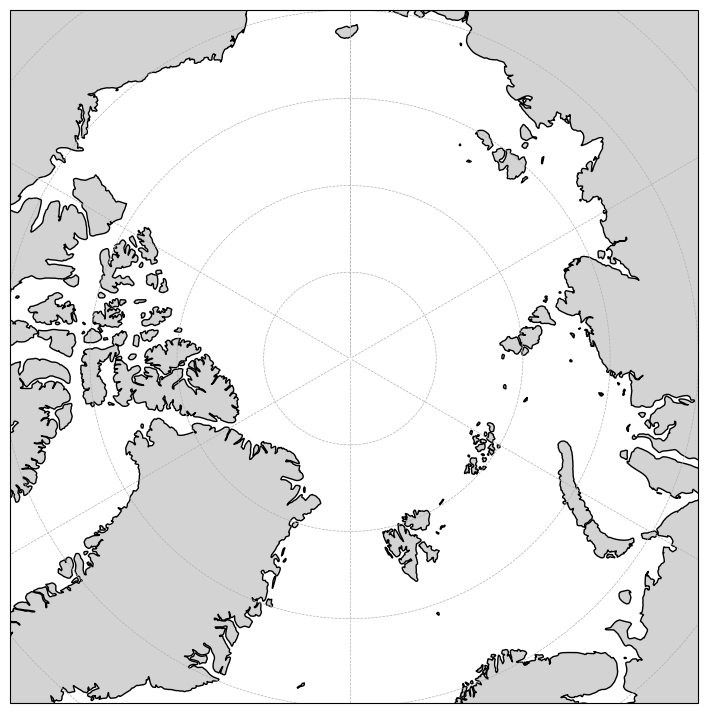

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# -------------------------------------------------
# 5. Plot results
# -------------------------------------------------
proj_map = ccrs.NorthPolarStereo()
proj_data = ccrs.PlateCarree()  # because u/v are on lat-lon grid

fig = plt.figure(figsize=(9, 9))
ax = plt.axes(projection=proj_map)
#
# # Focus on Arctic (change for Antarctic)
ax.set_extent([-180, 180, 70, 90], crs=proj_data)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.coastlines(resolution='50m')
ax.gridlines(draw_labels=False, linewidth=0.5, linestyle='--')

ax = add_streamline_plot_to_ax(u,v,ax)

# Saddles
sx = [s[0] for s in saddles]
sy = [s[1] for s in saddles]
plt.scatter(sx, sy, c='red', s=40, label='Saddles', zorder=5,transform=proj_data)


plt.title(f"Vector Field Topology: Saddles {year}")
plt.legend()
plt.show()